In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Generate a periodic time series for real data
t = np.linspace(0, 2 * np.pi, 100)
real_data = np.sin(t)

# Calculate max and min values at each time point (for illustration, we use a constant offset)
max_values = real_data + 0.5
min_values = real_data - 0.5

# Generate synthetic time series with similar periodicity
synthetic_data = np.sin(t + 0.2)  # Shifted sine wave for illustration

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(t, max_values, label='Max values', color='red')
plt.plot(t, min_values, label='Min values', color='blue')
plt.fill_between(t, min_values, max_values, color='gray', alpha=0.3)
plt.plot(t, synthetic_data, label='Synthetic data', color='orange')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Evaluation Metric for Synthetic Time Series')
plt.legend()
plt.show()


In [ ]:
def dynamic_time_warping_dist(X, Y, norm=np.linalg.norm):
    N = len(X)
    M = len(Y)
    D = np.zeros((N + 1, M + 1), dtype=float)
    D[:, 0] = np.inf
    D[0, :] = np.inf
    D[0][0] = 0

    for i in range(1, N + 1):
        for j in range(1, M + 1):
            m = min([D[i-1][j], D[i][j-1], D[i - 1][j - 1]])
            D[i][j] = norm(X[i - 1] - Y[j-1]) + m
    
    return D, D[N][M]


In [ ]:
from data_utils.dataset import PecanStreetDataset

data = PecanStreetDataset(normalize=True).data

data["na"] = data.apply(lambda x: np.isnan(x["grid"]).sum(), axis=1)


In [ ]:
import pandas as pd

gen1 = pd.Series([0.4268, 0.5523, 0.4448, 0.5027, 0.5177, 0.6535, 0.6747, 0.7472, 0.5214,
         0.3107, 0.6598, 0.6685, 0.8245, 0.3396, 0.2754, 0.3872, 0.5026, 0.5272,
         0.3035, 0.3311, 0.4019, 0.7185, 0.8432, 0.3549, 0.5299, 0.5152, 0.3924,
         0.5119, 0.6122, 0.4263, 0.6092, 0.6726, 0.6544, 0.7448, 0.5508, 0.4181,
         0.7782, 0.8716, 0.6260, 0.3872, 0.2818, 0.5349, 0.5347, 0.8896, 0.6796,
         0.1321, 0.7681, 0.4316, 0.8849, 0.6443, 0.2754, 0.4305, 0.3556, 0.6285,
         0.5837, 0.2451, 0.2837, 0.7609, 0.5354, 0.9319, 0.4514, 0.2632, 0.8530,
         0.4748, 0.6645, 0.3230, 0.6528, 0.6716, 0.7422, 0.2354, 0.4032, 0.4606,
         0.2942, 0.4498, 0.4860, 0.7774, 0.7191, 0.4783, 0.3699, 0.7323, 0.6639,
         0.5837, 0.6009, 0.4114, 0.6734, 0.4987, 0.7990, 0.5126, 0.3475, 0.7027,
         0.3561, 0.6606, 0.5166, 0.5397, 0.6111, 0.4090])

gen2 = pd.Series([0.5219, 0.6566, 0.5927, 0.6181, 0.5177, 0.2074, 0.2402, 0.4314, 0.7286,
         0.6659, 0.5205, 0.9059, 0.4305, 0.1115, 0.7054, 0.2671, 0.7664, 0.7258,
         0.3201, 0.3831, 0.6227, 0.6460, 0.5988, 0.1653, 0.8851, 0.7345, 0.4696,
         0.2593, 0.5084, 0.6222, 0.6460, 0.5787, 0.4409, 0.6243, 0.8426, 0.4974,
         0.5243, 0.3077, 0.6383, 0.8347, 0.3673, 0.3730, 0.5865, 0.1477, 0.8650,
         0.9583, 0.2334, 0.0791, 0.6824, 0.8908, 0.5962, 0.4637, 0.2086, 0.8390,
         0.5642, 0.6446, 0.6368, 0.3898, 0.7195, 0.5709, 0.7294, 0.3397, 0.2415,
         0.4168, 0.6553, 0.7886, 0.3073, 0.7841, 0.2258, 0.0864, 0.4577, 0.6291,
         0.5696, 0.9001, 0.4573, 0.2148, 0.7163, 0.5583, 0.5990, 0.7079, 0.5074,
         0.6685, 0.5315, 0.2543, 0.4997, 0.6022, 0.6259, 0.8325, 0.6012, 0.6266,
         0.2957, 0.2636, 0.5969, 0.7405, 0.5000, 0.4862])

gen3 = pd.Series([0.3925, 0.5289, 0.5974, 0.2812, 0.4937, 0.6966, 0.6950, 0.2335, 0.9326,
         0.7088, 0.4625, 0.3814, 0.2405, 0.6188, 0.6096, 0.2697, 0.2140, 0.7749,
         0.8222, 0.4400, 0.7510, 0.0858, 0.3349, 0.8388, 0.5010, 0.8916, 0.1850,
         0.4016, 0.1938, 0.7479, 0.6824, 0.6191, 0.5105, 0.8620, 0.3398, 0.3406,
         0.6736, 0.8911, 0.3457, 0.1178, 0.7170, 0.8272, 0.7285, 0.8866, 0.6957,
         0.4158, 0.5220, 0.1552, 0.6510, 0.9589, 0.3181, 0.0586, 0.6954, 0.7069,
         0.6426, 0.2569, 0.5124, 0.9186, 0.7920, 0.5622, 0.7645, 0.4525, 0.6339,
         0.5259, 0.5262, 0.5534, 0.5625, 0.7663, 0.4406, 0.3785, 0.6118, 0.5986,
         0.6690, 0.2131, 0.4802, 0.4630, 0.6122, 0.8126, 0.2447, 0.6731, 0.4136,
         0.7832, 0.6764, 0.2000, 0.8069, 0.9450, 0.2180, 0.3464, 0.2423, 0.2645,
         0.2098, 0.4412, 0.5058, 0.4792, 0.5300, 0.3509])

real1 = pd.Series([0.3729, 0.3480, 0.3327, 0.3368, 0.3737, 0.3726, 0.3688, 0.3670, 0.3357,
        0.3327, 0.3327, 0.3528, 0.3752, 0.3696, 0.3826, 0.4124, 0.4098, 0.4083,
        0.4087, 0.4501, 0.4467, 0.4438, 0.4322, 0.3573, 0.3405, 0.3364, 0.3647,
        0.3729, 0.3700, 0.3685, 0.3412, 0.3338, 0.3338, 0.3707, 0.3714, 0.3688,
        0.3595, 0.3338, 0.3338, 0.3398, 0.3782, 0.3703, 0.3681, 0.3453, 0.3338,
        0.3338, 0.3539, 0.3744, 0.3696, 0.3677, 0.3342, 0.3338, 0.3338, 0.3599,
        0.3718, 0.3696, 0.3547, 0.3338, 0.3338, 0.3793, 0.4352, 0.5403, 0.5023,
        0.4341, 0.4206, 0.4214, 0.4341, 0.4758, 0.4702, 0.4691, 0.4151, 0.3666,
        0.3461, 0.3401, 0.3834, 0.3864, 0.3837, 0.3767, 0.3483, 0.3480, 0.3509,
        0.3755, 0.5332, 0.4467, 0.3823, 0.3688, 0.3483, 0.3487, 0.3480, 0.3990,
        0.3998, 0.3923, 0.3934, 0.4710, 0.4113, 0.4438])

real2 = pd.Series([1.0000, 0.7589, 0.8523, 0.9872, 1.0000, 0.9801, 1.0000, 1.0000, 1.0000,
        1.0000, 0.8819, 0.6797, 0.5508, 0.6087, 0.9446, 0.8925, 0.7435, 0.7152,
        0.6004, 0.6016, 0.7069, 0.7329, 0.6206, 0.5981, 0.6407, 0.7589, 0.6880,
        0.9304, 1.0000, 0.7364, 0.5626, 0.5449, 0.6123, 0.6844, 0.5638, 0.4822,
        0.5898, 0.6040, 0.4928, 0.3758, 0.3888, 0.4727, 0.3698, 0.3438, 0.3639,
        0.4597, 0.3651, 0.3273, 0.3533, 0.4597, 0.3722, 0.3249, 0.3332, 0.4680,
        0.3781, 0.3214, 0.3296, 0.4562, 0.3781, 0.3237, 0.3344, 0.4349, 0.4574,
        0.3143, 0.2800, 0.3947, 0.3793, 0.3852, 0.8334, 0.5626, 0.5354, 0.2942,
        0.2776, 0.3474, 0.4361, 0.5543, 0.4231, 0.3486, 0.4171, 0.3166, 0.2942,
        0.3261, 0.4183, 0.3225, 0.2882, 0.3001, 0.4313, 0.3675, 0.3012, 0.3012,
        0.4065, 0.3391, 0.3296, 0.3746, 0.4940, 0.4585])


months = [9, 11, 7]
days = [6, 5, 1]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(gen2)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from data_utils.dataset import PecanStreetDataset

def plot_grid_profile(df, month, weekday):
    # Filter the DataFrame based on the specified month and weekday
    filtered_df = df[(df['month'] == month) & (df['weekday'] == weekday)]
    
    # Check if there are any rows after filtering
    if filtered_df.empty:
        print(f"No data available for month {month} and weekday {weekday}.")
        return

    # Convert the 'grid' column to a list of arrays
    grid_values = filtered_df['grid'].apply(np.array).values

    # Calculate the average grid values for each 15-minute interval across all filtered rows
    averaged_grid = np.mean(np.vstack(grid_values), axis=0)

    # Generate 96 timestamps for a day at 15-minute intervals
    timestamps = pd.date_range(start='00:00', end='23:45', freq='15T').strftime('%H:%M')

    # Ensure that the lengths match
    if len(averaged_grid) != len(timestamps):
        raise ValueError(f"Length of averaged_grid ({len(averaged_grid)}) does not match length of timestamps ({len(timestamps)}).")

    # Plot the averaged grid profile
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, averaged_grid, marker='o')
    plt.title(f'Grid Profile for Month {month} and Weekday {weekday}')
    plt.xlabel('Time of Day')
    plt.ylabel('Grid Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df = PecanStreetDataset(normalize=False).data
plot_grid_profile(df, month=5, weekday=3)

In [ ]:
df = PecanStreetDataset(normalize=True).data
plot_grid_profile(df, month=5, weekday=3)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_utils.dataset import PecanStreetDataset

def plot_grid_profile(df, month, weekday, dataid=None, ax=None):
    # Filter the DataFrame based on the specified month and weekday
    filtered_df = df[(df['month'] == month) & (df['weekday'] == weekday)]
    
    # Further filter by dataid if provided
    if dataid is not None:
        filtered_df = filtered_df[filtered_df['dataid'] == dataid]
    
    # Check if there are any rows after filtering
    if filtered_df.empty:
        print(f"No data available for month {month} and weekday {weekday} with dataid {dataid}.")
        return

    # Convert the 'grid' column to a list of arrays
    grid_values = filtered_df['grid'].apply(np.array).values

    # Calculate the average grid values for each 15-minute interval across all filtered rows
    averaged_grid = np.mean(np.vstack(grid_values), axis=0)

    # Generate 96 timestamps for a day at 15-minute intervals
    timestamps = pd.date_range(start='00:00', end='23:45', freq='15T').strftime('%H:%M')

    # Ensure that the lengths match
    if len(averaged_grid) != len(timestamps):
        raise ValueError(f"Length of averaged_grid ({len(averaged_grid)}) does not match length of timestamps ({len(timestamps)}).")

    # Plot the averaged grid profile
    if ax is None:
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, averaged_grid, marker='o')
        title = f'Grid Profile for Month {month} and Weekday {weekday}'
        if dataid is not None:
            title += f' (DataID: {dataid})'
        plt.title(title)
        plt.xlabel('Time of Day')
        plt.ylabel('Grid Values')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        ax.plot(timestamps, averaged_grid, marker='o', label=f'DataID: {dataid}')

def plot_all_users_grid_profile(df, month, weekday):
    unique_dataids = df['dataid'].unique()
    fig, ax = plt.subplots(figsize=(12, 6))
    for dataid in unique_dataids:
        plot_grid_profile(df, month, weekday, dataid, ax=ax)
    
    title = f'Grid Profile for Month {month} and Weekday {weekday} for All Users'
    plt.title(title)
    plt.xlabel('Time of Day')
    plt.ylabel('Grid Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Load the dataset
df = PecanStreetDataset(normalize=True).data

# Plot for all users
plot_all_users_grid_profile(df, month=11, weekday=3)

In [ ]:
def plot_daily_usage_profiles(df, dataid, month, weekday):
    # Filter the DataFrame based on the specified user id, month, and weekday
    filtered_df = df[(df['dataid'] == dataid) & (df['month'] == month) & (df['weekday'] == weekday)]
    
    # Check if there are any rows after filtering
    if filtered_df.empty:
        print(f"No data available for user {dataid}, month {month}, and weekday {weekday}.")
        return

    grid_values = filtered_df['grid'].apply(np.array).values
    timestamps = pd.date_range(start='00:00', end='23:45', freq='15T').strftime('%H:%M')

    plt.figure(figsize=(12, 6))
    for i, daily_grid in enumerate(grid_values):
        plt.plot(timestamps, daily_grid, marker='o', label=f'Day {i+1}')

    title = f'Daily Usage Profiles for User {dataid}, Month {month}, Weekday {weekday}'
    plt.title(title)
    plt.xlabel('Time of Day')
    plt.ylabel('Grid Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

df = PecanStreetDataset(normalize=False).data
plot_daily_usage_profiles(df, dataid=3687, month=5, weekday=0)

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from data_utils.dataset import PecanStreetDataset, prepare_dataloader, split_dataset
from generator.acgan import ACGAN  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = PecanStreetDataset(normalize=True, user_id=27)
train_dataset, val_dataset = split_dataset(data)
model = ACGAN(
    input_dim=1,
    noise_dim=512,
    embedding_dim=512,
    output_dim=96,
    learning_rate=1e-4,
    weight_path="runs/",
)
model.train(train_dataset, val_dataset, batch_size=32, num_epoch=100)


def generate_and_plot_series(model, day_labels, month_labels, data, month, weekday):
    series1 = model.generate([day_labels, month_labels]).squeeze()
    series2 = model.generate([day_labels, month_labels]).squeeze()
    series3 = model.generate([day_labels, month_labels]).squeeze()

    timestamps = pd.date_range(start='00:00', periods=96, freq='15T').strftime('%H:%M')

    filtered_data = data[(data['month'] == month) & (data['weekday'] == weekday)]
    real_profiles = filtered_data.sample(3)['grid'].values
    real_profile1 = np.array(real_profiles[0])
    real_profile2 = np.array(real_profiles[1])
    real_profile3 = np.array(real_profiles[2])

    # Plot all series on the same plot
    plt.figure(figsize=(15, 6))
    plt.plot(timestamps, series1, label='Generated Profile 1')
    plt.plot(timestamps, series2, label='Generated Profile 2')
    plt.plot(timestamps, series3, label='Generated Profile 3')
    plt.plot(timestamps, real_profile1, label='Real Profile 1', linestyle='--')
    plt.plot(timestamps, real_profile2, label='Real Profile 2', linestyle='--')
    plt.plot(timestamps, real_profile3, label='Real Profile 3', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Generated and Real Time Series Profiles')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

day_labels = torch.tensor([7]).to(device)
month_labels = torch.tensor([5]).to(device)

generate_and_plot_series(model, day_labels, month_labels, data.data, 5, 7)

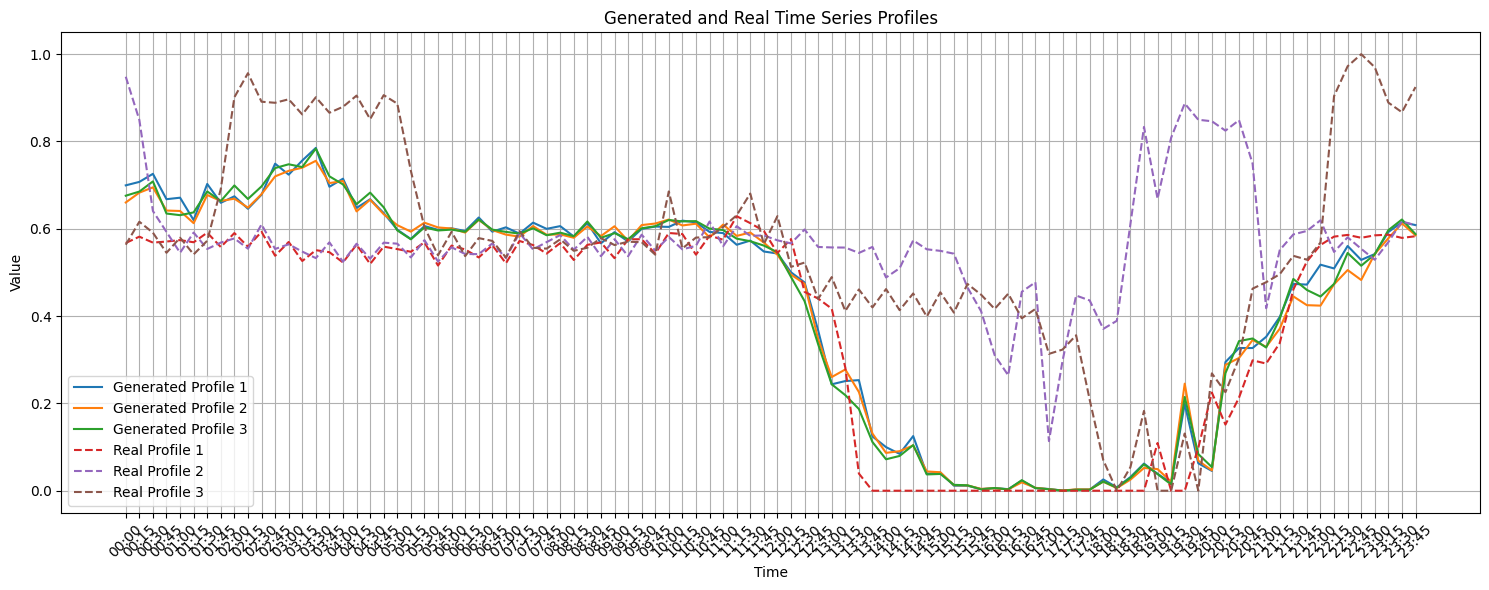

In [18]:
import numpy as np

day_labels = torch.tensor([6]).to(device)
month_labels = torch.tensor([9]).to(device)
generate_and_plot_series(model, day_labels, month_labels, data.data, 9, 6)